# Taller clasificación 

## 1. Descarga de imagenes
La descarga de las imagenes se realizo con la API de GEE para usar con python.

# zona de estudio 
La zona seleccionada para el ejercicio es el Parque Nacional Natural Tinigua. Se encuentra en el departamento del Meta, Colombia, y forma parte del Área de Manejo Especial La Macarena (AMEM), junto con otros parques como Sumapaz, Cordillera de los Picachos y Sierra de La Macarena. Este parque es un corredor ecológico que conecta los ecosistemas andino, amazónico y de la Orinoquía, facilitando el flujo de especies y la conservación de la biodiversidad.

Con una extensión de aproximadamente 214,000 hectáreas, Tinigua alberga una gran diversidad de flora y fauna. Sus bosques húmedos tropicales y bosques inundables son el hábitat de especies emblemáticas como el jaguar (Panthera onca), el puma (Puma concolor), la danta (Tapirus terrestris), diversas especies de monos, guacamayas y el caimán llanero. Además, el parque conserva cuatro cuencas hidrográficas: los ríos Guayabero, Guaduas, Perdido y Duda, que contribuyen a la formación del río Guaviare y la macrocuenca del Orinoco.

Sin embargo, Tinigua enfrenta amenazas significativas debido a la deforestación, que se ha acelerado desde 2017. Se estima que aproximadamente el 29.3% del área protegida ha sido intervenida, principalmente por la expansión de la ganadería extensiva y la ocupación ilegal de tierras. Esta pérdida de cobertura vegetal afecta la biodiversidad y altera los servicios ecosistémicos, como la regulación hídrica y la calidad del agua.

Dada su importancia ecológica y las amenazas que enfrenta, es crucial monitorear los cambios en la cobertura del suelo en el Parque Nacional Natural Tinigua para implementar estrategias de conservación efectivas y garantizar la protección de este valioso ecosistema.

Revisaremos un ejercicio de clasificación de cobertura para el primer trimestre de 2024.

### Revisión y descarga de imagenes

In [1]:
import ee
import geemap

# Inicializar Earth Engine
ee.Initialize()

# Cargar zona de estudio
aoi = ee.FeatureCollection("users/Pra2019/Tinigua")

# Colección Sentinel-2 SR, baja nubosidad
collection = ee.ImageCollection("COPERNICUS/S2_SR") \
    .filterBounds(aoi) \
    .filterDate("2024-01-01", "2024-03-31") \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Máscara de nubes usando la banda SCL (opcional, más estricto)
def mask_clouds(img):
    scl = img.select('SCL')
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
    return img.updateMask(mask)

collection_masked = collection.map(mask_clouds)

# Selecciona solo bandas de 10m
bands_10m = ['B2','B3','B4','B8']
mosaic = collection_masked.select(bands_10m).median().clip(aoi)

# --- VISUALIZACIÓN EN EL MAPA ---
Map = geemap.Map(center=[2.7, -74.0], zoom=10)
rgb_vis = {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}
Map.addLayer(mosaic, rgb_vis, "Mosaico Sentinel-2 Tinigua")
Map.addLayer(aoi, {}, "Zona de estudio")
Map

/opt/conda/lib/python3.13/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Map(center=[2.7, -74.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [ ]:


# --- EXPORTACIÓN A GOOGLE DRIVE ---
geemap.ee_export_image_to_drive(
    mosaic,
    description='tinigua_sentinel2_drive',   # Nombre de la tarea en GEE
    folder='GEE_exports',                    # Carpeta destino en tu Google Drive
    region=aoi.geometry(),
    scale=10,

)
print("¡La exportación fue enviada a Google Drive! Revisa tu carpeta 'GEE_exports' cuando termine la tarea.")

¡La exportación fue enviada a Google Drive! Revisa tu carpeta 'GEE_exports' cuando termine la tarea.


#### Librerias relevantes para el ejercicio.

In [1]:
# Import modules from python standard library
import os
import pprint
import random

# Import Geopandas for vector analysis (https://geopandas.org)
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Import the RSGISLib modules for the notebook
import rsgislib
import rsgislib.classification
import rsgislib.classification.classsklearn
import rsgislib.tools.filetools
import rsgislib.tools.mapping
import rsgislib.tools.plotting
import rsgislib.vectorutils
import rsgislib.zonalstats
from sklearn.ensemble import RandomForestClassifier

# scikit-learn imports
from sklearn.model_selection import GridSearchCV

### Visaulización de imagenes y puntos de entrenamiento.

   id  Clase      Descripcio                   geometry
0   1      1    Bosque denso   POINT (-74.11838 2.4965)
1   2      1    Bosque denso   POINT (-74.1397 2.50083)
2   3      1    Bosque denso  POINT (-74.13109 2.52548)
3   4      1    Bosque denso  POINT (-74.05687 2.48759)
4   5      2  Cuerpo de agua   POINT (-74.14318 2.5623)


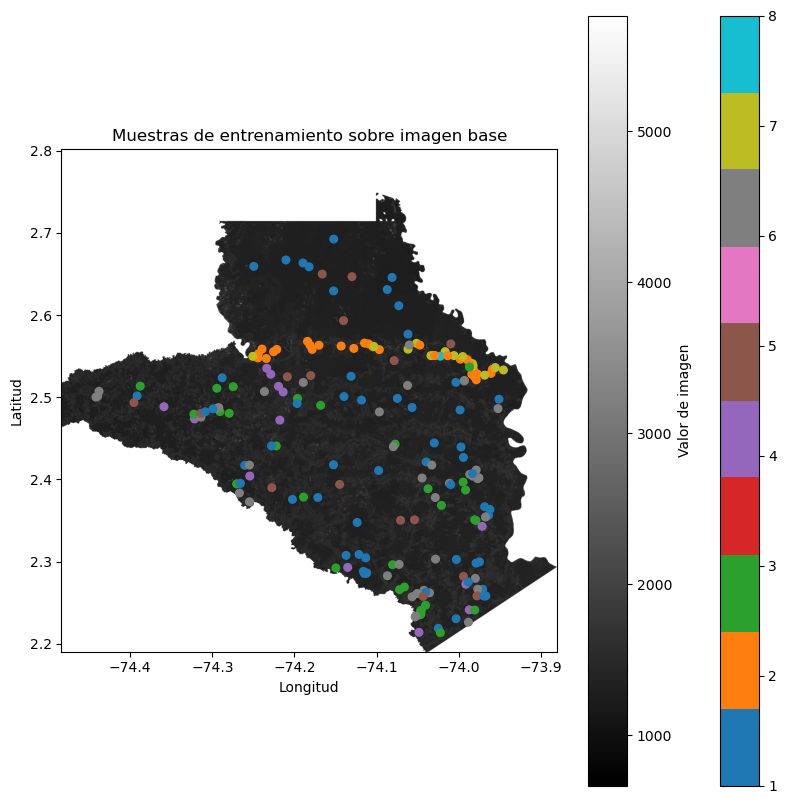

In [4]:
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd

# Ruta a tu imagen raster y shapefile
ruta_raster = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_sentinel2_drive.tif"
ruta_shapefile = "/root/Geoprocesamiento_talleres-1/geo_data/data_vector/entrenamiento_tini.shp"

# Cargar la imagen raster (usa la banda que prefieras para fondo, ejemplo: banda 1)
with rasterio.open(ruta_raster) as src:
    img = src.read(1)  # puedes cambiar el número de banda
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    crs_raster = src.crs

# Cargar el shapefile con muestras
muestras = gpd.read_file(ruta_shapefile)
print(muestras.head())

# Asegúrate de que ambos tengan el mismo CRS (proyección)
if muestras.crs != crs_raster:
    muestras = muestras.to_crs(crs_raster)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(img, cmap='gray', extent=extent)
muestras.plot(ax=ax, column='Clase', cmap='tab10', markersize=30, legend=True)
plt.title("Muestras de entrenamiento sobre imagen base")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.colorbar(im, ax=ax, label="Valor de imagen")
plt.show()

In [8]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import numpy as np

# 1. Carga el shapefile de muestras
ruta_shapefile = "/root/Geoprocesamiento_talleres-1/geo_data/data_vector/tinitgua.shp"
gdf = gpd.read_file(ruta_shapefile)
print(gdf.columns)  # Chequea el nombre del campo de clase, por ejemplo, 'clase' o 'class'

# 2. Cargar la imagen de referencia (asegúrate de que tienen el mismo CRS)
ruta_raster = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_sentinel2_drive.tif"
with rasterio.open(ruta_raster) as src:
    out_shape = (src.height, src.width)
    transform = src.transform
    crs = src.crs
    profile = src.profile

# (Opcional: reproyecta el shapefile si los CRS no coinciden)
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

# 3. Define el campo de clase
campo_clase = "Clase"  # Cambia por el nombre real de tu campo de clase

# 4. Prepara los pares (geometría, valor de clase)
shapes = zip(gdf.geometry, gdf[campo_clase])

# 5. Rasteriza
raster_muestras = rasterize(
    shapes=shapes,
    out_shape=out_shape,
    fill=0,  # Valor para fuera de muestra
    transform=transform,
    dtype=np.uint8,
    all_touched=False  # True para polígonos, False para puntos; ajusta si lo necesitas
)

# 6. Guarda el raster de clases (GeoTIFF)
output_path = "/root/Geoprocesamiento_talleres-1/geo_data/muestras_rasterizadas.tif"
profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(raster_muestras, 1)

print(f"¡Listo! Raster de muestras guardado en {output_path}")

Index(['Clase', 'Descripcio', 'geometry'], dtype='object')
¡Listo! Raster de muestras guardado en /root/Geoprocesamiento_talleres-1/geo_data/muestras_rasterizadas.tif


In [9]:
import rasterio

img_path = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_sentinel2_drive.tif"  # Cambia la ruta si es necesario
with rasterio.open(img_path) as src:
    image = src.read()  # Esto carga todas las bandas como (bandas, filas, columnas)

In [10]:
import rasterio

mask_path = "/root/Geoprocesamiento_talleres-1/geo_data/muestras_rasterizadas.tif"  # Usa la ruta correcta
with rasterio.open(mask_path) as msk:
    mask = msk.read(1)  # Lee la banda 1 como un array 2D de numpy
    # Encuentra dónde hay muestras
mask_flat = mask.flatten()
rows, cols = mask.shape
image_reshaped = image.reshape(image.shape[0], -1).T  # (pixels, bands)

# Solo donde mask > 0 (hay clase)
idx = np.where(mask_flat > 0)[0]
X = image_reshaped[idx]  # Datos (valores de las bandas)
y = mask_flat[idx]       # Etiquetas (la clase)

print("Datos de entrenamiento extraídos:", X.shape, y.shape)

Datos de entrenamiento extraídos: (201, 4) (201,)


In [11]:
mask_valida = y != 8
X = X[mask_valida]
y = y[mask_valida]

In [12]:
import numpy as np
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Clase {cls}: {count} muestras")


Clase 1: 57 muestras
Clase 2: 30 muestras
Clase 3: 30 muestras
Clase 4: 13 muestras
Clase 5: 17 muestras
Clase 6: 39 muestras
Clase 7: 14 muestras


In [13]:
from sklearn.utils import resample
import numpy as np

data = np.hstack((X, y.reshape(-1, 1)))
classes, counts = np.unique(y, return_counts=True)
min_count = np.min(counts)

data_balanced = np.vstack([
    resample(data[data[:, -1] == clase], replace=False, n_samples=min_count, random_state=42)
    for clase in classes
])

X_bal = data_balanced[:, :-1]
y_bal = data_balanced[:, -1]
print("Datos balanceados:", X_bal.shape, y_bal.shape)

Datos balanceados: (91, 4) (91,)


In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# 1. Dataset original
X_full = X
y_full = y

# 2. Dataset balanceado (undersampling)
data = np.hstack((X, y.reshape(-1, 1)))
classes, counts = np.unique(y, return_counts=True)
min_count = np.min(counts)
data_balanced = np.vstack([
    resample(data[data[:, -1] == clase], replace=False, n_samples=min_count, random_state=42)
    for clase in classes
])
X_bal = data_balanced[:, :-1]
y_bal = data_balanced[:, -1]


In [15]:
# 3. Separar en train/test (usamos 30% test para ambos)
# --- Original ---
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42, stratify=y_full)
# --- Balanceado ---
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_bal, y_bal, test_size=0.3, random_state=42, stratify=y_bal)

# 4. Entrenamiento y predicción
# --- Original con class_weight='balanced' ---
clf_full = RandomForestClassifier(class_weight='balanced', random_state=42)
clf_full.fit(X_train, y_train)
y_pred_full = clf_full.predict(X_test)

# --- Balanceado ---
clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(Xb_train, yb_train)
y_pred_bal = clf_bal.predict(Xb_test)


In [ ]:
# 5. Métricas y matriz de confusión
print("----- MÉTRICAS: Todos los datos (class_weight='balanced') -----")
print(classification_report(y_test, y_pred_full, digits=3))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_full))



----- MÉTRICAS: Todos los datos (class_weight='balanced') -----
              precision    recall  f1-score   support

           1      0.789     0.882     0.833        17
           2      1.000     1.000     1.000         9
           3      0.800     0.889     0.842         9
           4      1.000     0.500     0.667         4
           5      0.667     0.800     0.727         5
           6      1.000     0.750     0.857        12
           7      0.800     1.000     0.889         4

    accuracy                          0.850        60
   macro avg      0.865     0.832     0.831        60
weighted avg      0.869     0.850     0.848        60

Matriz de confusión:
 [[15  0  0  0  2  0  0]
 [ 0  9  0  0  0  0  0]
 [ 1  0  8  0  0  0  0]
 [ 0  0  1  2  0  0  1]
 [ 1  0  0  0  4  0  0]
 [ 2  0  1  0  0  9  0]
 [ 0  0  0  0  0  0  4]]

----- MÉTRICAS: Dataset balanceado (undersampling) -----
              precision    recall  f1-score   support

         1.0      0.750     0.750  

In [33]:
print("\n----- MÉTRICAS: Dataset balanceado (undersampling) -----")
print(classification_report(yb_test, y_pred_bal, digits=3))
print("Matriz de confusión:\n", confusion_matrix(yb_test, y_pred_bal))


----- MÉTRICAS: Dataset balanceado (undersampling) -----
              precision    recall  f1-score   support

         1.0      0.750     0.750     0.750         4
         2.0      1.000     1.000     1.000         4
         3.0      0.600     0.750     0.667         4
         4.0      1.000     0.500     0.667         4
         5.0      0.750     0.750     0.750         4
         6.0      0.667     0.500     0.571         4
         7.0      0.667     1.000     0.800         4

    accuracy                          0.750        28
   macro avg      0.776     0.750     0.744        28
weighted avg      0.776     0.750     0.744        28

Matriz de confusión:
 [[3 0 0 0 1 0 0]
 [0 4 0 0 0 0 0]
 [0 0 3 0 0 1 0]
 [0 0 0 2 0 0 2]
 [1 0 0 0 3 0 0]
 [0 0 2 0 0 2 0]
 [0 0 0 0 0 0 4]]


#### ¿Qué significa cada métrica?
Precision: De los que el modelo predijo como esa clase, ¿cuántos estaban bien?

Recall: De todos los verdaderos de esa clase, ¿cuántos predijo bien?

F1-score: Promedio armónico entre precisión y recall (mejor si ambos son altos).

Support: Cuántos ejemplos reales había de cada clase en el test.

# Mapa y entrenamiento clasificador 

In [ ]:
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split





### Extracción de datos y entrenamiento

In [11]:

input_img = "/root/Geoprocesamiento_talleres-1/geo_data/tinigua_sentinel2_drive.tif"
samples_img = "/root/Geoprocesamiento_talleres-1/geo_data/muestras_rasterizadas.tif"

with rasterio.open(input_img) as src:
    img = src.read()
    img_meta = src.meta

with rasterio.open(samples_img) as src:
    muestras = src.read(1)

# Extrae muestras de entrenamiento
mask = muestras > 0
X = img[:, mask].T
y = muestras[mask]

# Filtra clase 8 si existe
mask_valida = y != 8
X = X[mask_valida]
y = y[mask_valida]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Entrena clasificador
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
# ----- CLASIFICAR UNA VENTANA -----
raster_path = input_img
fila_ini, col_ini = 4000, 4000   # píxel inicial 
n_filas, n_cols = 1900, 2000     # tamaño ventana 

with rasterio.open(raster_path) as src:
    window = Window(col_ini, fila_ini, n_cols, n_filas)
    bands = src.read(window=window)
    img_shape = bands.shape[1:]
    X_img = bands.reshape(bands.shape[0], -1).T
    mapa_pred = clf.predict(X_img).reshape(img_shape)
    profile = src.profile
    profile.update(dtype=rasterio.uint8, count=1, height=n_filas, width=n_cols,
                   transform=rasterio.windows.transform(window, src.transform))
    with rasterio.open("prediccion_ventana.tif", "w", **profile) as dst:
        dst.write(mapa_pred.astype(rasterio.uint8), 1)
    # Coordenadas para ejes
    transform = profile['transform']
    x_coords = np.arange(n_cols) * transform[0] + transform[2]
    y_coords = np.arange(n_filas) * transform[4] + transform[5]



### Visualización mapa de clasificación

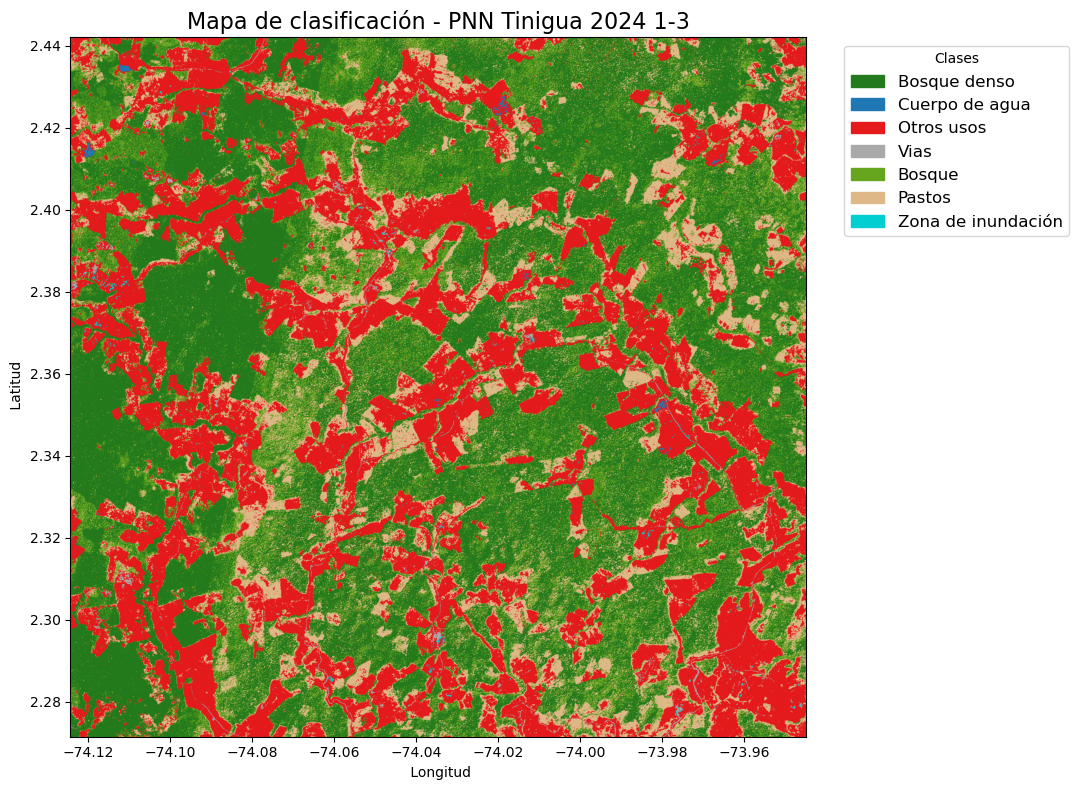

In [19]:

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

colores = [
    "#237a1c",  # Bosque denso
    '#1f78b4',  # Cuerpo de agua
    '#e41a1c',  # Otros usos
    '#A9A9A9',  # Vias
    '#66a61e',  # Bosque
    '#DEB887',  # Pastos
    '#00CED1'   # Zona de inundación
]
clases = [1, 2, 3, 4, 5, 6, 7]
nombres_clases = [
    "Bosque denso", 
    "Cuerpo de agua", 
    "Otros usos", 
    "Vias", 
    "Bosque", 
    "Pastos", 
    "Zona de inundación"
]

plt.figure(figsize=(12, 8))
cmap = ListedColormap(colores)
bounds = [c - 0.5 for c in clases] + [clases[-1] + 0.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.imshow(mapa_pred, cmap=cmap, norm=norm,
           extent=(x_coords[0], x_coords[-1], y_coords[-1], y_coords[0]))

plt.title("Mapa de clasificación - PNN Tinigua 2024 1-3", fontsize=16)
plt.xlabel(" Longitud")
plt.ylabel(" Latitud")

legend_patches = [Patch(color=colores[i], label=nombres_clases[i]) for i in range(len(clases))]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.04, 1), loc='upper left', title="Clases", fontsize=12)
plt.tight_layout()
plt.show()

La clasificación evidencia grandes zonas deforestadas, lo que se ajusta al ainformacion registrada  la cual  afirma que durante el primer trimestre de 2024, la deforestación en el Parque Nacional Natural Tinigua mostró un repunte significativo, reflejando una tendencia nacional al alza tras dos años de reducción de la pérdida de bosques. Según informes técnicos de Parques Nacionales Naturales de Colombia, entre enero y marzo de 2024 se identificaron cuatro polígonos con pérdida reciente de bosque en el sector Guayabero–Perdido, municipio de La Macarena, con una afectación total de 126,21 hectáreas de selva húmeda, el ecosistema predominante en el parque. Este análisis se realizó mediante imágenes satelitales y monitoreo multitemporal, confirmando la persistencia de actividades ilegales de tala y rocería dentro del área protegida (Paz Cardona, 2025; Parques Nacionales, 2024).